In [35]:
!pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch, logging, os, json, re
import libcst as cst
import pandas as pd
from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, PreTrainedTokenizerBase, PreTrainedModel
from huggingface_hub import model_info
from huggingface_hub.utils import RepositoryNotFoundError
from datasets import load_dataset
from absl import logging as absl_logging

In [30]:
def setup_logging() -> None:

    level = os.getenv("LOG_LEVEL", "INFO").upper()
    logging.basicConfig(
        level=level,
        format="%(asctime)s [%(levelname)s] %(message)s"
    )
    logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
    logging.getLogger("transformers").setLevel(logging.WARNING)

    absl_logging.set_verbosity(absl_logging.ERROR)
    absl_logging.set_stderrthreshold("error")

setup_logging()
logger = logging.getLogger(__name__)

In [45]:
class Obfuscator:

    def run(self, code: str, level:str = "low", rename_template : str = "v") -> str:
        level = level.lower().strip()
        module = cst.parse_module(code)

        if level == "low":
            module = module.visit(self.__RenameValues(rename_template))
        elif level == "medium":
            module = module.visit(self.__RenameValues(rename_template))
            module = module.visit(self.__StripComments())
            module = module.visit(self.__StripDocstrings())
        else:
            raise ValueError(f"Unknown level: {level}")


        return module.code

    class __RenameValues(cst.CSTTransformer):

        def __init__(self, rename_template: str = "v") -> None:

            self.rename_template = rename_template
            self.scopes = []
            self.counter = 0

        def visit_FunctionDef(self, node: cst.FunctionDef):
            self.__push_scope()

            for p in node.params.params:
                self.__bind_current(p.name.value)

            return None

        def leave_FunctionDef(self, original, updated):
            self.__pop_scope()
            return updated

        def leave_Param(self, original: cst.Param, updated: cst.Param):

            new = self.__find(original.name.value)

            if new is not None and original.name.value not in ("self", "cls"):
                return updated.with_changes(name=cst.Name(new))

            return updated

        def leave_Assign(self, original: cst.Assign, updated: cst.Assign):

            new_targets = []
            for target in updated.targets:

                t = target.target

                if isinstance(t, cst.Name):

                    target_value = t.value
                    self.__bind_current(target_value)
                    new = self.__find(target_value)

                    if new is not None:
                        t = cst.Name(new)

                new_targets.append(target.with_changes(target=t))

            return updated.with_changes(targets=new_targets)

        def leave_Name(self, original: cst.Name, updated: cst.Name):

            new = self.__find(original.value)

            if new is not None:
                return updated.with_changes(value=new)

            return updated

        def leave_Comment(self, original: cst.Comment, updated: cst.Comment):
            renamed = self.__rename_text(updated.value)
            if renamed == updated.value:
                return updated
            return updated.with_changes(value=renamed)


        def leave_SimpleString(self, original: cst.SimpleString, updated: cst.SimpleString):

            if not re.match(r"^([rubfRUBF]*)(\"\"\"|\'\'\')", updated.value):
                return updated

            renamed = self.__rename_text(updated.value)

            if renamed == updated.value:
                return updated

            return updated.with_changes(value=renamed)


        def __rename_text(self, text: str) -> str:

            mapping = {}

            for sc in self.scopes:
                mapping.update(sc)

            if not mapping:
                return text

            for old in sorted(mapping.keys(), key=len, reverse=True):

                if old in ("self", "cls"):
                    continue

                new = mapping[old]
                text = re.sub(rf"(?<![A-Za-z0-9_]){re.escape(old)}(?![A-Za-z0-9_])", new, text)

            return text


        def __push_scope(self):
            self.scopes.append({})

        def __pop_scope(self):
            self.scopes.pop()

        def __new_name(self) -> str:
            name = f"{self.rename_template}{self.counter}"
            self.counter += 1
            return name


        def __find(self, name: str):

            for sc in reversed(self.scopes):
                if name in sc:
                    return sc[name]
            return None

        def __bind_current(self, old: str) -> None:

            if old in ("self", "cls"):
                return

            cur = self.scopes[-1]
            if old not in cur:
                cur[old] = self.__new_name()

    class __StripComments(cst.CSTTransformer):
        def leave_Comment(self, original: cst.Comment, updated: cst.Comment):
            return cst.RemovalSentinel.REMOVE

    class __StripDocstrings(cst.CSTTransformer):
        def leave_Module(self, original, updated):
            return updated.with_changes(body=self.__strip(updated.body))

        def leave_ClassDef(self, original, updated):

            if isinstance(updated.body, cst.IndentedBlock):

                new_body = self.__strip(updated.body.body)
                return updated.with_changes(body=updated.body.with_changes(body=new_body))

            return updated

        def leave_FunctionDef(self, original, updated):

            if isinstance(updated.body, cst.IndentedBlock):
                new_body = self.__strip(updated.body.body)
                return updated.with_changes(body=updated.body.with_changes(body=new_body))
            return updated

        def __strip(self, statemnts):

            if not statemnts:
                return statemnts

            i = 0
            while (i < len(statemnts) and isinstance(statemnts[i], cst.EmptyLine)):

                i += 1

            if i < len(statemnts):

                first = statemnts[i]

                if (isinstance(first, cst.SimpleStatementLine)
                    and len(first.body) == 1
                    and isinstance(first.body[0], cst.Expr)
                    and isinstance(first.body[0].value, cst.SimpleString)):
                    return list(statemnts[:i]) + list(statemnts[i + 1:])

            return statemnts

## Obfuscator

The **Obfuscator** reduces the readability of source code while fully preserving
its original behavior. It applies a controlled set of transformations to hide
implementation details and limit code transparency.

Typical transformations include:
- Renaming identifiers
- Removing comments
- Removing docstrings

This is useful when sharing, distributing, or deploying code where clarity
should be reduced without affecting functionality.

---

## Obfuscation Levels

The obfuscator supports multiple levels that balance protection strength and
structural simplicity.

### `low`
Lightweight obfuscation.
- Renames identifiers only
- Keeps comments and docstrings intact

### `medium`
Stronger obfuscation.
- Renames identifiers
- Removes comments
- Removes docstrings

Each level builds on the previous one by applying additional transformation
passes, while ensuring identical runtime behavior.

Low level obfuscation example

In [40]:
code = "\n\ndef function_name(a_value : int, b_value : int) -> float:\n    \"\"\" This docstring is intentionally left as a placeholder. \n Detailed documentation will be added during a later development stage.\n    \"\"\"\n"

obf = Obfuscator()
print(code)
print(obf.run(code, "low"))



def function_name(a_value : int, b_value : int) -> float:
    """ This docstring is intentionally left as a placeholder. 
 Detailed documentation will be added during a later development stage.
    """



def function_name(v0 : int, v1 : int) -> float:
    """ This docstring is intentionally left as a placeholder. 
 Detailed documentation will be added during a later development stage.
    """



Medium obfuscation example:

In [46]:
code = "\n\ndef function_name(a_value : int, b_value : int) -> float:\n    \"\"\" This docstring is intentionally left as a placeholder. \n Detailed documentation will be added during a later development stage.\n    \"\"\"\n"

obf = Obfuscator()
print(code)
print(obf.run(code, "medium"))



def function_name(a_value : int, b_value : int) -> float:
    """ This docstring is intentionally left as a placeholder. 
 Detailed documentation will be added during a later development stage.
    """



def function_name(v0 : int, v1 : int) -> float:
    pass



## Issues

- **Identifier replacement inside docstrings**

  Variable renaming is currently applied without semantic awareness of natural
  language text. As a result, if a variable name matches a common word and
  appears inside a docstring as plain text, it may be unintentionally replaced.

  This can lead to altered or misleading documentation content, even though
  the program behavior remains unchanged.


---

In [23]:
def huggingface_completion(prompt: str,
                           tokenizer: PreTrainedTokenizerBase,
                           model: PreTrainedModel,
                           device: str = "cpu",
                           max_tokens: int = 128) -> str:

    """
    Creates a text completion from the given prompt using a Hugging Face
    transformer model.

    The prompt is first tokenized, then passed to the model for autoregressive
    generation on the selected device. The resulting tokens are decoded back
    into a text string.

    Args:
        prompt (str): Text input serving as the generation prompt.
        tokenizer (PreTrainedTokenizerBase): Tokenizer associated with the model.
        model (PreTrainedModel): Pretrained Hugging Face language model.
        device (str): Inference device (e.g. "cpu" or "cuda").
        max_tokens (int): Maximum number of tokens to generate.

    Returns:
        str: The generated text output.

    Notes: this function adds to the given prompt flag (<extra_id_0>), some of codeT5 models requires this flag for proper code placement.
    """

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False,
            num_beams=5,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    raw = tokenizer.decode(out_ids[0], skip_special_tokens=False)

    if "<extra_id_0>" in raw:
        after = raw.split("<extra_id_0>", 1)[1]
    else:
        after = raw

    for stop in ("<extra_id_1>", "</s>"):
        if stop in after:
            after = after.split(stop, 1)[0]

    for tok in ("<pad>", "<s>", "</s>"):
        after = after.replace(tok, "")

    completion = after.strip()
    return completion

In [5]:
def generate_completions(model_name="Salesforce/codet5p-220m-py",
                         save_filename = "generated_completions",
                         lines: int = 20):

    """
    Generates multiple text completions from openai/openai_humaneval Dataset using the specified language model
    and saves the results to a file.

    The function loads the given model, produces a fixed number of completions,
    and stores the generated outputs for later analysis or reuse.

    Args:
        model_name (str): Name or path of the Hugging Face model to use.
        save_filename (str): Base name of the file used to save the results.
        lines (int): Number of completions to generate.
    """

    dataset_name = "openai/openai_humaneval"
    logger.info(f"Loading dataset '{dataset_name}' ...")

    try:
        ds = load_dataset(dataset_name, split="test")
    except Exception as e:
        logger.error(f"Failed to load dataset '{dataset_name}': {type(e).__name__}")
        raise

    logger.info(
        f"Dataset '{dataset_name}' loaded successfully "
        f"(samples={len(ds)})"
    )

    ####################################
    ### IF U WANT TO USE LOCAL DATASET
    # ds = load_dataset(
    #     "json",
    #     data_files="./something.jsonl",
    #     split="train"
    # )

    subds = ds.select(range(lines))

    results = []
    obf = Obfuscator()

    try:
        model_info(model_name)
        logger.debug(f" Model '{model_name}' found.")
    except RepositoryNotFoundError:
        logger.error(f"[ERROR] Model '{model_name}' does NOT exist on Hugging Face Hub. Exiting...")
        return

    logger.info(f"Loading model '{model_name}'...")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    except Exception as e:
        logger.error(
            f"Failed to load model '{model_name}': {type(e).__name__}"
        )
        raise

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    logger.info(
        f"Model '{model_name}' loaded successfully "
        f"(device={device})"
    )

    for data in subds:

        logger.info(f"Running completion generator for {data['task_id']} ...")

        original_prompt = data["prompt"]
        low_obf_prompt = obf.run(original_prompt, "low")
        medium_obf_prompt = obf.run(original_prompt, "medium")

        logger.debug(f"[original prompt] Running completion generator for {data['task_id']} ...")
        original_completion = huggingface_completion(original_prompt, tokenizer, model, device)

        logger.debug(f"[low obf prompt] Running completion generator for {data['task_id']} ...")
        low_obf_completion = huggingface_completion(low_obf_prompt, tokenizer, model, device)

        logger.debug(f"[med obf prompt] Running completion generator for {data['task_id']} ...")
        medium_obf_completion = huggingface_completion(medium_obf_prompt, tokenizer, model, device)

        variants = [
            ("original", original_prompt, original_completion),
            ("low", low_obf_prompt, low_obf_completion),
            ("medium", medium_obf_prompt, medium_obf_completion),
        ]

        for level, prompt, completion in variants:

            results.append({
                "Task id": data["task_id"],
                "Obfuscation level": level,
                "Prompt": prompt,
                "Completion": completion,
                "Canonical solution": data["canonical_solution"],
            })

    logger.info(f"Generation of completions completed. Saving results to {save_filename}.json ...")


    os.makedirs(os.path.dirname(save_filename), exist_ok=True)
    with open(f"{save_filename}.json", "w") as f:
        json.dump(results, f, indent=4)


In [6]:
# model_name = "Salesforce/codet5p-220m-py"
# generate_completions(model_name, "completions/codet5s_220m_py", 20)
#
# model_name = "Salesforce/codet5-base"
# generate_completions(model_name, "completions/codet5-base", 20)

model_name = "Salesforce/codet5-small"
generate_completions(model_name, "completions/codet5-small", 20)

2025-12-17 15:52:41,779 [INFO] Loading dataset 'openai/openai_humaneval' ...
2025-12-17 15:52:43,448 [INFO] Dataset 'openai/openai_humaneval' loaded successfully (samples=164)
2025-12-17 15:52:43,581 [INFO] Loading model 'Salesforce/codet5p-220m-py'...
2025-12-17 15:53:03,432 [INFO] Model 'Salesforce/codet5p-220m-py' loaded successfully (device=cpu)
2025-12-17 15:53:03,445 [INFO] Running completion generator for HumanEval/0 ...
2025-12-17 15:53:12,155 [INFO] Running completion generator for HumanEval/1 ...
2025-12-17 15:53:29,896 [INFO] Running completion generator for HumanEval/2 ...
2025-12-17 15:53:40,991 [INFO] Running completion generator for HumanEval/3 ...
2025-12-17 15:53:49,360 [INFO] Running completion generator for HumanEval/4 ...
2025-12-17 15:53:57,283 [INFO] Running completion generator for HumanEval/5 ...
2025-12-17 15:54:09,062 [INFO] Running completion generator for HumanEval/6 ...
2025-12-17 15:54:27,975 [INFO] Running completion generator for HumanEval/7 ...
2025-12-

In [7]:
df_codet5_220m_py = pd.read_json("completions/codet5s_220m_py.json")
df_codet5_small = pd.read_json("completions/codet5-small.json")
df_codet5_base = pd.read_json("completions/codet5-base.json")

In [8]:

def privacy_score(original_prompt: str, obfuscated_prompt: str) -> float:
    """
    Normalized Levenshtein distance in [0, 1] (higher = more obfuscated / less similar).
    """
    a = original_prompt or ""
    b = obfuscated_prompt or ""

    denom = max(len(a), len(b))

    if denom == 0:
        return 0.0

    dist = Levenshtein.distance(a, b)

    return dist / denom


def utility_score(reference: str, completion: str, scorer) -> float:
    """
    ROUGE score in [0, 1] (higher = closer to reference).
    """
    r = reference or ""
    c = completion or ""

    result = scorer.score(r, c)

    ### also u can try rouge-2, but its sometimes way too sensitive(DONT FORGET TO CHANGE SCORER)
    rouge = result.get("rouge1")

    return float(getattr(rouge, "fmeasure", 0.0))


def evaluate_completions(dataframe: pd.DataFrame) -> pd.DataFrame:

    scores = []
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)

    original_prompt_by_task = (
        dataframe[dataframe["Obfuscation level"] == "original"]
        .set_index("Task id")["Prompt"]
        .to_dict()
    )

    for _, row in dataframe.iterrows():
        completion = row["Completion"]
        canonical_solution = row["Canonical solution"]

        item = {
            "Task id": row["Task id"],
            "Obfuscation level": row["Obfuscation level"],
            "Utility Score": utility_score(completion, canonical_solution, scorer),
            "Privacy Score": privacy_score(original_prompt_by_task[row["Task id"]], row["Prompt"])
        }
        scores.append(item)

    return scores

scores_base = pd.DataFrame(evaluate_completions(df_codet5_base))
scores_small = pd.DataFrame(evaluate_completions(df_codet5_small))
scores_220m_py = pd.DataFrame(evaluate_completions(df_codet5_220m_py))

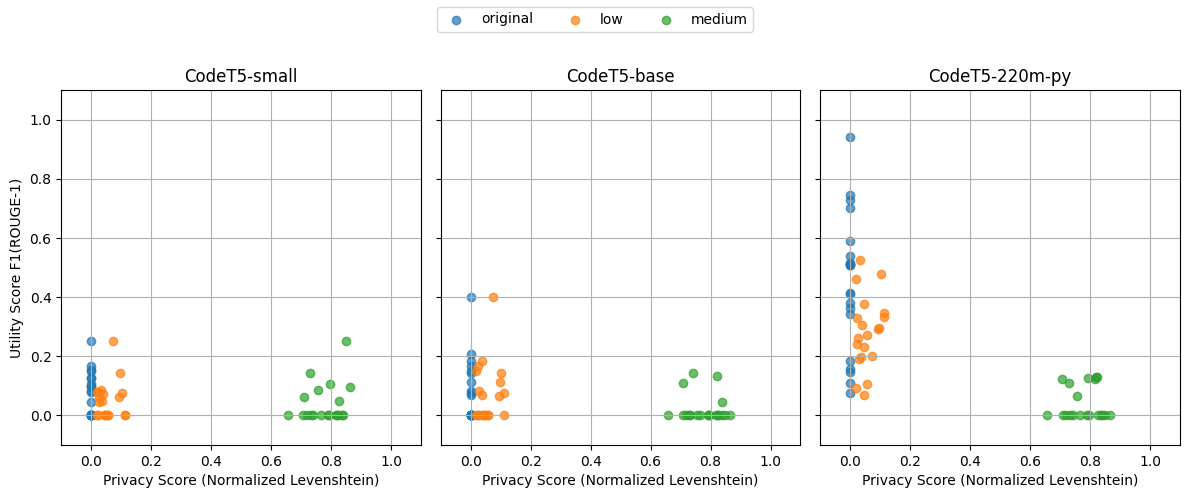

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

plots = [
    (scores_small, "CodeT5-small"),
    (scores_base, "CodeT5-base"),
    (scores_220m_py, "CodeT5-220m-py")
]

for ax, (scores_df, title) in zip(axes, plots):
    for level in scores_df["Obfuscation level"].unique():
        subset = scores_df[scores_df["Obfuscation level"] == level]
        ax.scatter(
            subset["Privacy Score"],
            subset["Utility Score"],
            label=level,
            alpha=0.7
        )

    ax.set_title(title)
    ax.set_xlabel("Privacy Score (Normalized Levenshtein)")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

axes[0].set_ylabel("Utility Score F1(ROUGE-1)")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [34]:
l = df_codet5_220m_py.iloc[0]["Prompt"]
print(l)


obf = Obfuscator()
print(obf.run(l, "medium"))

from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """

from typing import List


def has_close_elements(v0: List[float], v1: float) -> bool:
    pass

